# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preprocessing

Read the data in a pandas dataframe

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
weather_data = pd.read_csv("/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv")
weather_data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,8.3,13.3,338,NNW,1012.0,29.89,0.0,0.00,24,30,25.3,77.5,10.0,6.0,7.0,9.5,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,6.9,11.2,320,NW,1012.0,29.88,0.1,0.00,94,75,19.0,66.2,10.0,6.0,5.0,11.4,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,9.4,15.1,280,W,1011.0,29.85,0.0,0.00,29,0,24.6,76.4,10.0,6.0,5.0,13.9,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,7.4,11.9,215,SW,1007.0,29.75,0.3,0.01,61,100,3.8,38.9,2.0,1.0,2.0,8.5,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,8.1,13.0,150,SSE,1011.0,29.85,0.0,0.00,89,50,28.7,83.6,10.0,6.0,8.0,12.5,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
humidity_mean = weather_data["humidity"].mean()
humidity_std = weather_data["humidity"].std()
weather_data["humidity"] = (weather_data["humidity"] - humidity_mean) / humidity_std

pressure_mean = weather_data["pressure_in"].mean()
pressure_std = weather_data["pressure_in"].std()
weather_data["pressure_in"] = (weather_data["pressure_in"] - pressure_mean) / pressure_std

weather_data = weather_data[(weather_data["humidity"] <= 1) & (weather_data["humidity"] >= -1)]
weather_data = weather_data[(weather_data["pressure_in"] <= 1) & (weather_data["pressure_in"] >= -1)]

From the EDA, we have seen that the features that we want to keep are latitude, humidity, pressure, and uv_index. 

In [5]:
X, y = weather_data[["latitude", "humidity", "pressure_in", "uv_index", "last_updated"]], weather_data["temperature_celsius"]

In [6]:
def get_minutes(x):
    date_obj = datetime.strptime(x, "%Y-%m-%d %H:%M")
    target_date = datetime.fromtimestamp(0)
    time_diff = date_obj - target_date
    total_minutes = time_diff.total_seconds() // 60
    return total_minutes

Preprocess the data. The date has to be converted into the number of minutes from a reference point. We also need to normalize the humidity and pressure variables.

In [7]:
X['minutes'] = X['last_updated'].apply(get_minutes)
least_minutes = X["minutes"].min()
X["minutes"] = X["minutes"] - least_minutes

<ipython-input-7-732a5d05b944>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['minutes'] = X['last_updated'].apply(get_minutes)
<ipython-input-7-732a5d05b944>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["minutes"] = X["minutes"] - least_minutes


In [8]:
X = X.drop(columns=['last_updated'])

In [9]:
X

,latitude,humidity,pressure_in,uv_index,minutes
3,42.5000,-0.084725,-0.880283,2.0,540.0
5,17.1200,0.846690,-0.107995,1.0,180.0
7,40.1800,-0.935148,0.471221,4.0,660.0
9,48.2000,-0.003733,-0.107995,5.0,540.0
10,40.4000,0.198749,0.905633,5.0,660.0
...,...,...,...,...,...
47343,-8.5167,0.846690,-0.783747,0.0,352605.0
47344,0.3156,-0.611178,0.326417,10.1,352020.0
47349,-34.8581,0.198749,-0.252799,2.1,351765.0
47355,-15.4167,-0.611178,-0.832015,14.1,352005.0


In [10]:
y

3         6.3
5        26.0
7        19.0
9        16.0
10       17.0
         ... 
47343    28.1
47344    28.2
47349    22.2
47355    28.0
47356    25.6
Name: temperature_celsius, Length: 21862, dtype: float64

Split the data into train and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

# Build XGBoost models

Building 4 different models with different hyperparameters.

In [12]:
model1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [13]:
model2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1,
                          max_depth = 10, alpha = 10, n_estimators = 10)

In [14]:
model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [15]:
model4 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.1,
                          max_depth = 7, alpha = 10, n_estimators = 10)

In [16]:
model1.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [17]:
model2.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [18]:
model3.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [19]:
model4.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [20]:
predictions1 = model1.predict(X_test)

In [21]:
predictions2 = model2.predict(X_test)

In [22]:
predictions3 = model3.predict(X_test)

In [23]:
predictions4 = model4.predict(X_test)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

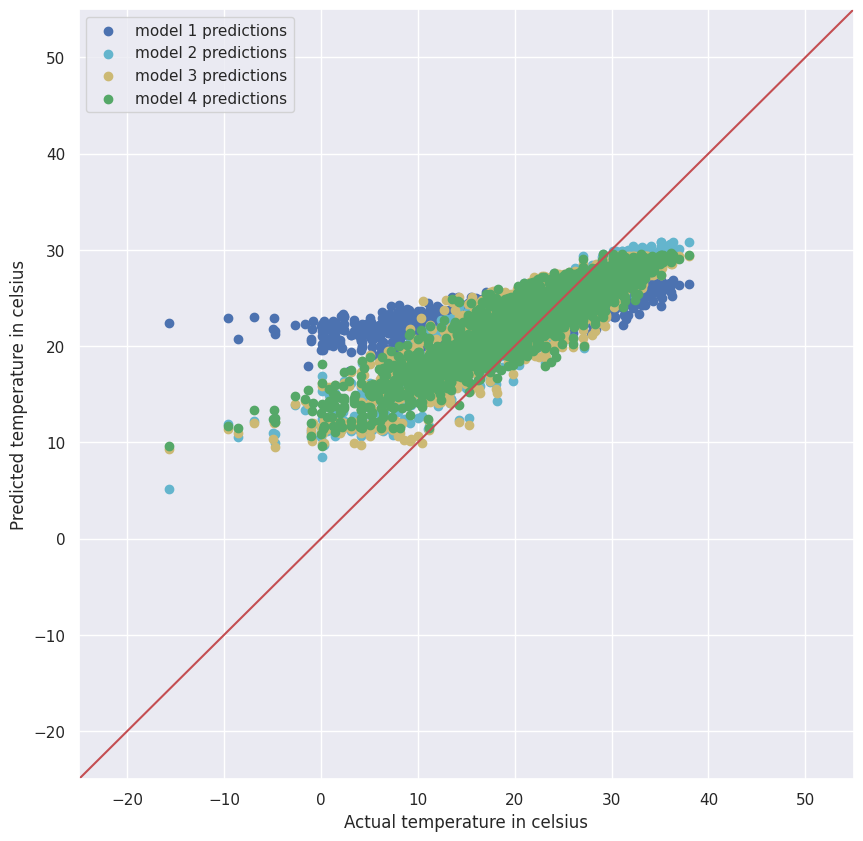

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions1, c = 'b', label='model 1 predictions')
plt.scatter(y_test, predictions2, c = 'c', label='model 2 predictions')
plt.scatter(y_test, predictions3, c = 'y', label='model 3 predictions')
plt.scatter(y_test, predictions4, c = 'g', label='model 4 predictions')
plt.xlim(-25, 55)
plt.ylim(-25, 55)
plt.axline((0, 0), slope=1, color='r')
plt.xlabel("Actual temperature in celsius")
plt.ylabel("Predicted temperature in celsius")
plt.legend()
plt.show()

None of the models perform well enough.